In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
#from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.io import arff

import sys
import importlib
sys.path.append('../../helpers/')
import helper
sys.path.append('../../model/')
from ourModel import Classifier, train, test

In [19]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")
print()

GPU is available and being used



# Prepare Dataset 

Load Dataset

In [21]:
data_file_path = '../../datasets/helena/Helena.arff'
df = arff.loadarff(data_file_path)
df = pd.DataFrame(df[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65196 entries, 0 to 65195
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   class   65196 non-null  object 
 1   V1      65196 non-null  float64
 2   V2      65196 non-null  float64
 3   V3      65196 non-null  float64
 4   V4      65196 non-null  float64
 5   V5      65196 non-null  float64
 6   V6      65196 non-null  float64
 7   V7      65196 non-null  float64
 8   V8      65196 non-null  float64
 9   V9      65196 non-null  float64
 10  V10     65196 non-null  float64
 11  V11     65196 non-null  float64
 12  V12     65196 non-null  float64
 13  V13     65196 non-null  float64
 14  V14     65196 non-null  float64
 15  V15     65196 non-null  float64
 16  V16     65196 non-null  float64
 17  V17     65196 non-null  float64
 18  V18     65196 non-null  float64
 19  V19     65196 non-null  float64
 20  V20     65196 non-null  float64
 21  V21     65196 non-null  float64
 22

Clean Data

In [22]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
df.head()

,class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27
0,b'41',0.005521,0.080556,0.110417,0.490822,0.586406,0.066414,0.092206,0.116352,0.379310,...,-0.342986,78.6894,17.23780,21.504200,14.43730,17.37800,9.61674,-0.609370,1.044830,1.481790
1,b'92',0.049398,0.147917,0.541667,0.542865,0.515608,0.105128,0.475550,0.049555,0.383460,...,2.639370,59.7879,5.39341,3.819610,11.49240,3.92947,5.91423,1.409210,4.749540,1.103820
2,b'24',0.548663,1.000000,1.000000,0.397029,0.627398,1.023440,1.004220,0.027381,0.451337,...,0.137427,58.1429,-3.36598,-0.037489,10.63470,2.66018,3.93377,-0.898220,2.137790,1.054470
3,b'29',0.023073,0.206250,0.238889,0.622998,0.764067,0.202599,0.177892,0.071232,0.531712,...,0.477009,55.4798,-1.05109,-4.755360,13.36710,2.85206,9.65162,0.224397,-0.220216,-0.273287
4,b'91',0.224427,0.433333,0.902083,0.814199,0.576879,0.344413,0.822975,0.026121,0.425875,...,0.521306,76.8475,-19.37170,32.270700,9.41442,4.34345,8.67710,-1.587580,1.117870,-0.545338


Change targets to corresponding column name

In [23]:
##CHANGE ME
targets = [
    'class'
]
# encode the labels of the targets and create decoding dict
label_encoders = []
encoded_to_labels = []
for x in range(len(targets)):
    label_encoders.append(LabelEncoder())
    df[targets[x]] = label_encoders[x].fit_transform(df[targets[x]])
    encoded_to_labels.append({encoded: label for label, encoded in zip(label_encoders[x].classes_, label_encoders[x].transform(label_encoders[x].classes_))})



In [24]:
for x in targets:
    print(df[x].value_counts())
print(encoded_to_labels)

76    4005
51    3063
35    2992
33    2623
32    2216
      ... 
73     121
52     121
26     119
28     116
2      111
Name: class, Length: 100, dtype: int64
[{0: b'0', 1: b'1', 2: b'10', 3: b'11', 4: b'12', 5: b'13', 6: b'14', 7: b'15', 8: b'16', 9: b'17', 10: b'18', 11: b'19', 12: b'2', 13: b'20', 14: b'21', 15: b'22', 16: b'23', 17: b'24', 18: b'25', 19: b'26', 20: b'27', 21: b'28', 22: b'29', 23: b'3', 24: b'30', 25: b'31', 26: b'32', 27: b'33', 28: b'34', 29: b'35', 30: b'36', 31: b'37', 32: b'38', 33: b'39', 34: b'4', 35: b'40', 36: b'41', 37: b'42', 38: b'43', 39: b'44', 40: b'45', 41: b'46', 42: b'47', 43: b'48', 44: b'49', 45: b'5', 46: b'50', 47: b'51', 48: b'52', 49: b'53', 50: b'54', 51: b'55', 52: b'56', 53: b'57', 54: b'58', 55: b'59', 56: b'6', 57: b'60', 58: b'61', 59: b'62', 60: b'63', 61: b'64', 62: b'65', 63: b'66', 64: b'67', 65: b'68', 66: b'69', 67: b'7', 68: b'70', 69: b'71', 70: b'72', 71: b'73', 72: b'74', 73: b'75', 74: b'76', 75: b'77', 76: b'78', 77: b'79'

# Beyond here you dont have to mess with the dataframe anymore.

### Structure data for pytorch and split into training and testing splits

In [25]:
# dataset wrapper for the dataframe. Just a way to structure the data that pytorch likes and needs to then wrap with dataloader.

class DatasetWrapper(Dataset):
    def __init__(self, df : pd.DataFrame, target : str):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.int64).values

        self.scalar = StandardScaler()
        self.x = self.scalar.fit_transform(df.drop(columns=targets)).astype(np.float32)

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
exp_dataset = DatasetWrapper(df, target=targets) # UPDATE for your experiments

# Split training and testing samples
train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

batch_size = 256 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Train length: 52156, Test length: 13040


## Model instantiation

In [26]:
num_features =  len(train_dataset[0][0])
num_targets =   len(train_dataset[0][1])
classes_per_target = [len(df[t].unique()) for t in targets ]

print(f"Features: {num_features}")
print(f"Targets: {num_targets}")
print(f"Classes per Target: {classes_per_target}")

Features: 27
Targets: 1
Classes per Target: [100]


In [27]:
#Updated with f1
model = Classifier(n_features=num_features, 
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=2, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model


## Loss functions

In [28]:
loss_functions = []
#This loop could easily be adapted to us BinaryCrossEntropy for binary class and Cross for multi class
for x in targets:
    loss_functions.append(nn.CrossEntropyLoss())

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


## Train Test Loop

In [52]:
epochs = 150 #Set the number of epochs

In [53]:
train_losses = []
test_losses = []
train_accuracies = [[] for _ in range(num_targets)]
test_accuracies =  [[] for _ in range(num_targets)]

for t in range(epochs):
  train_loss, train_accuracy= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy, all_predictions, all_targets, f1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  #Losses
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  #Accuracies
  for i in range(num_targets):
    train_accuracies[i].append(train_accuracy[i])
    test_accuracies[i].append(test_accuracy[i])
 
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"

  train_metrics = f"Train: Loss {train_loss:.2f}"
  for target, Acc in zip(targets, train_accuracy):
    train_metrics += f", {target} Accuracy: {Acc:.2f}"
  
  test_metrics = f"Test: Loss {test_loss:.2f}"
  for target, Acc, fone in zip(targets, test_accuracy, f1):
    test_metrics += f", {target} Accuracy: {Acc:.2f}, {target} F1: {fone:.2f}"

  print(f"{epoch_str:15} | {train_metrics} | {test_metrics}")


Epoch [ 1/150]  | Train: Loss 2.66, class Accuracy: 0.35 | Test: Loss 2.91, class Accuracy: 0.32, class F1: 0.28
Epoch [ 2/150]  | Train: Loss 2.65, class Accuracy: 0.35 | Test: Loss 2.90, class Accuracy: 0.32, class F1: 0.28
Epoch [ 3/150]  | Train: Loss 2.65, class Accuracy: 0.35 | Test: Loss 2.90, class Accuracy: 0.32, class F1: 0.28
Epoch [ 4/150]  | Train: Loss 2.65, class Accuracy: 0.35 | Test: Loss 2.89, class Accuracy: 0.32, class F1: 0.28
Epoch [ 5/150]  | Train: Loss 2.65, class Accuracy: 0.35 | Test: Loss 2.89, class Accuracy: 0.32, class F1: 0.28
Epoch [ 6/150]  | Train: Loss 2.65, class Accuracy: 0.35 | Test: Loss 2.89, class Accuracy: 0.32, class F1: 0.27
Epoch [ 7/150]  | Train: Loss 2.65, class Accuracy: 0.35 | Test: Loss 2.89, class Accuracy: 0.32, class F1: 0.28
Epoch [ 8/150]  | Train: Loss 2.65, class Accuracy: 0.35 | Test: Loss 2.90, class Accuracy: 0.32, class F1: 0.28
Epoch [ 9/150]  | Train: Loss 2.65, class Accuracy: 0.35 | Test: Loss 2.89, class Accuracy: 0.32

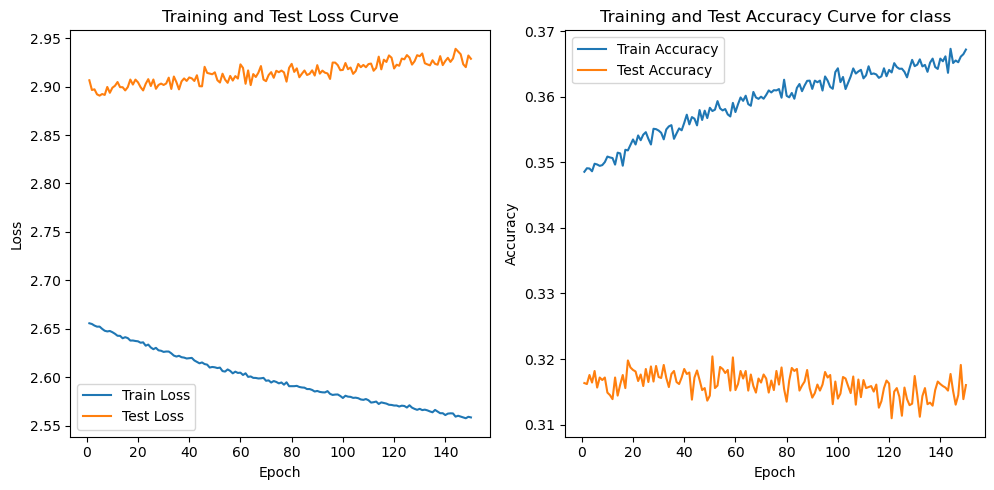

In [54]:
plot_num = 1
# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, plot_num)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plot_num+=1

for i in range(num_targets):
    plt.subplot(1, 3, plot_num)
    plt.plot(range(1, epochs+1), train_accuracies[i], label='Train Accuracy')
    plt.plot(range(1, epochs+1), test_accuracies[i], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Test Accuracy Curve for {targets[i]}')
    plt.legend()
    plot_num+=1


plt.tight_layout()
plt.tight_layout()
plt.show()


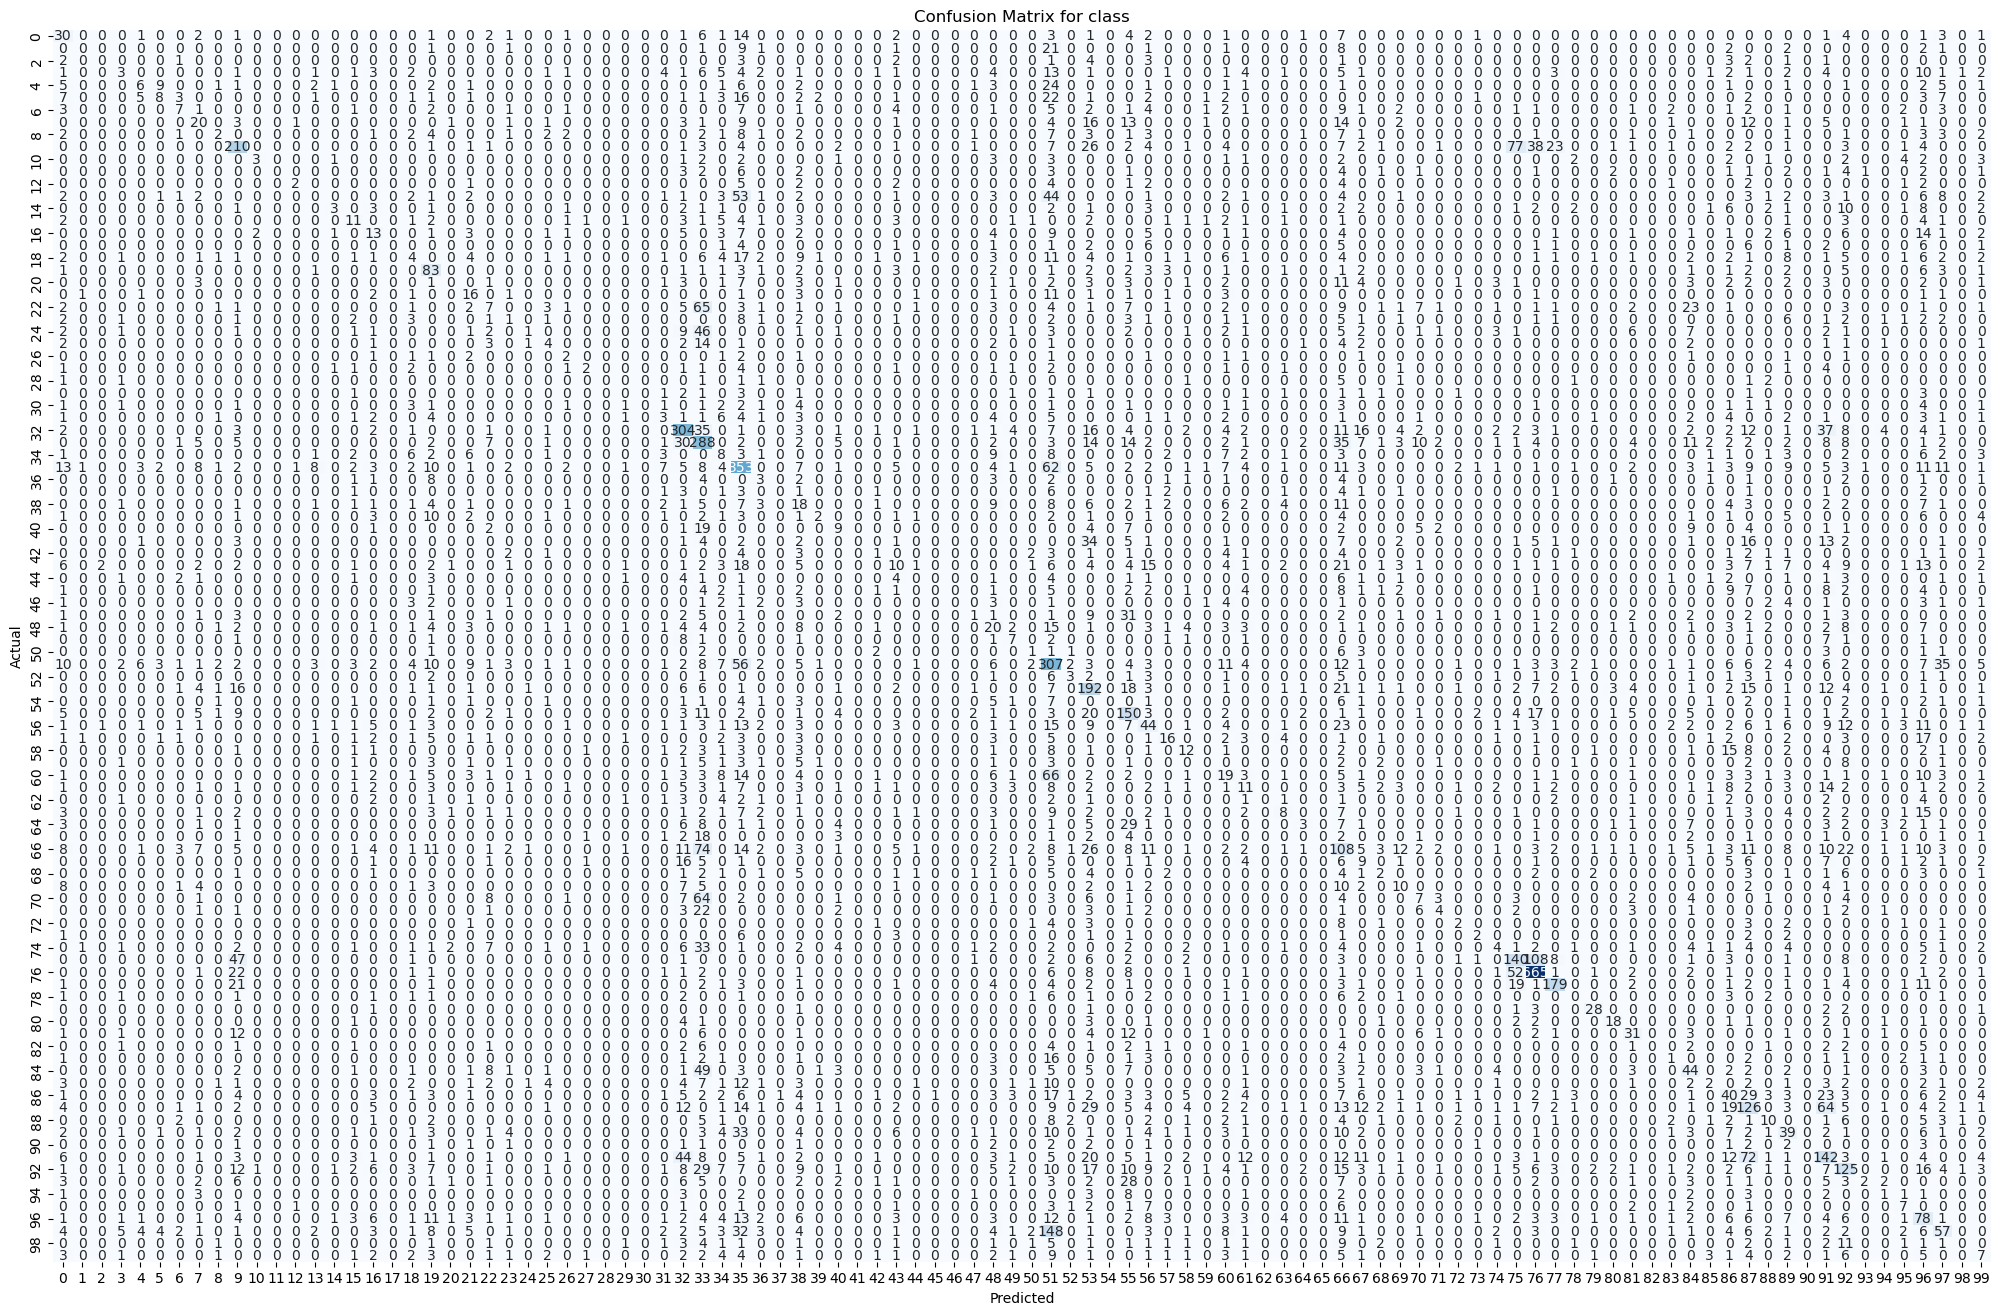

In [55]:
conf_matrix = confusion_matrix(all_targets[0], all_predictions[0])
plt.figure(figsize=(25, 16))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {targets[0]}')
plt.show()